### Q: Can we get the CNNs to overfit to the data?

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES
from netam.framework import (
    SHMoofDataset,
    RSSHMBurrito,
    trimmed_shm_model_outputs_of_crepe,
)
from epam.torch_common import pick_device

from epam import sequences, evaluation
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices

from shmex.shm_data import load_shmoof_dataframes, dataset_dict
from shmex import shm_zoo
from shmex.shm_eval import ragged_np_pcp_encoding, oe_plot_of, show_figure

We're just going to use shmoof training data, the same data used to train the context NT model.

In [2]:
site_count = 500
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
subsampled_train_df = train_df.iloc[::int(len(train_df)/5000)].copy().reset_index(drop=True)

In [4]:
def oe_plot_of_crepe(crepe, pcp_df, title):
    crepe.to("cpu")
    ratess, cspss = trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
    site_count = crepe.encoder.site_count
    mut_indicators, base_idxss, masks = ragged_np_pcp_encoding(pcp_df["parent"], pcp_df["child"], site_count)
    fig, oe_results = oe_plot_of(ratess, masks, pcp_df["branch_length"], mut_indicators, title)
    oe_results.pop("counts_twinx_ax")
    return fig, oe_results


In [5]:
fivemer_crepe = framework.load_crepe("trained_models/fivemer")

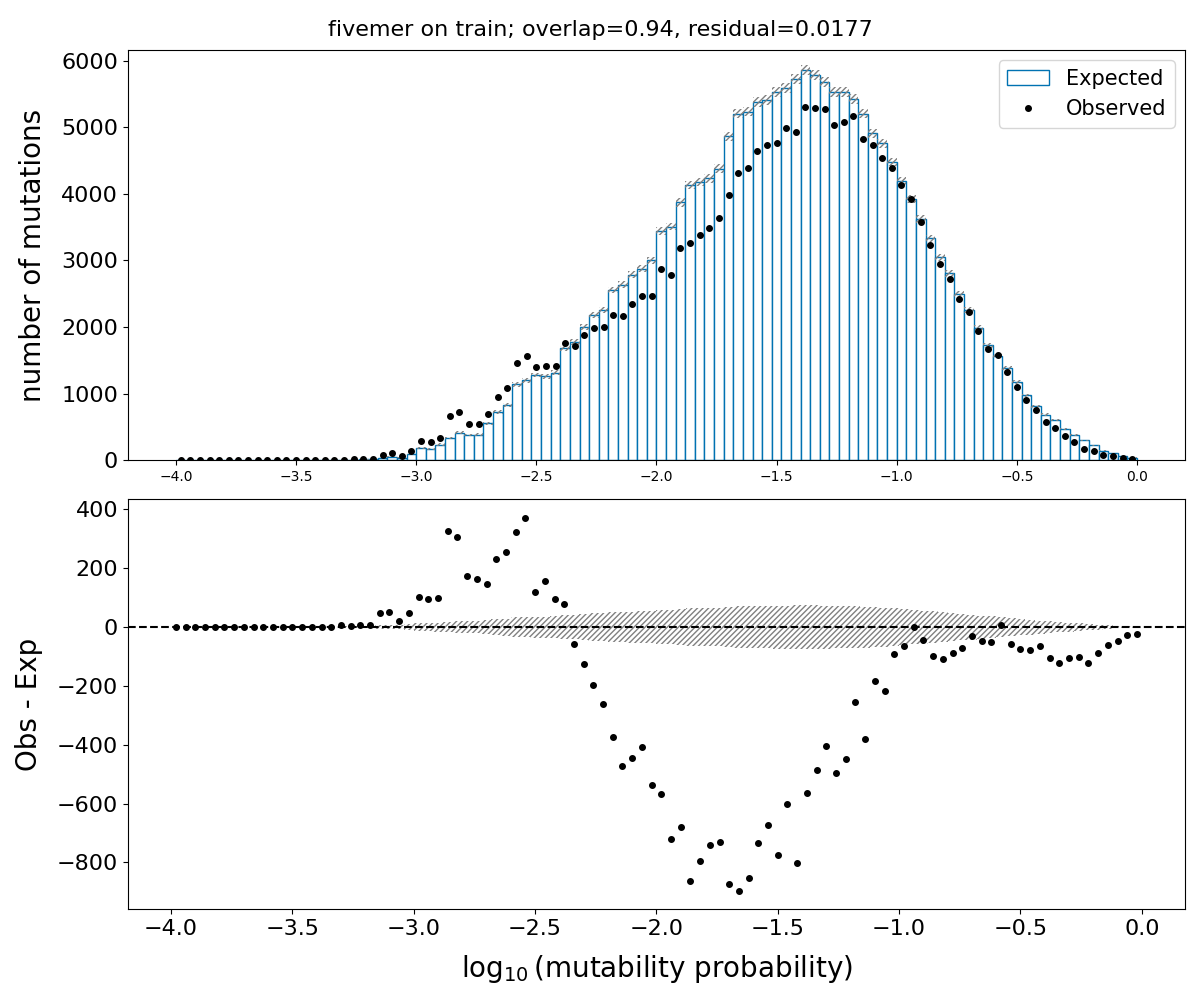

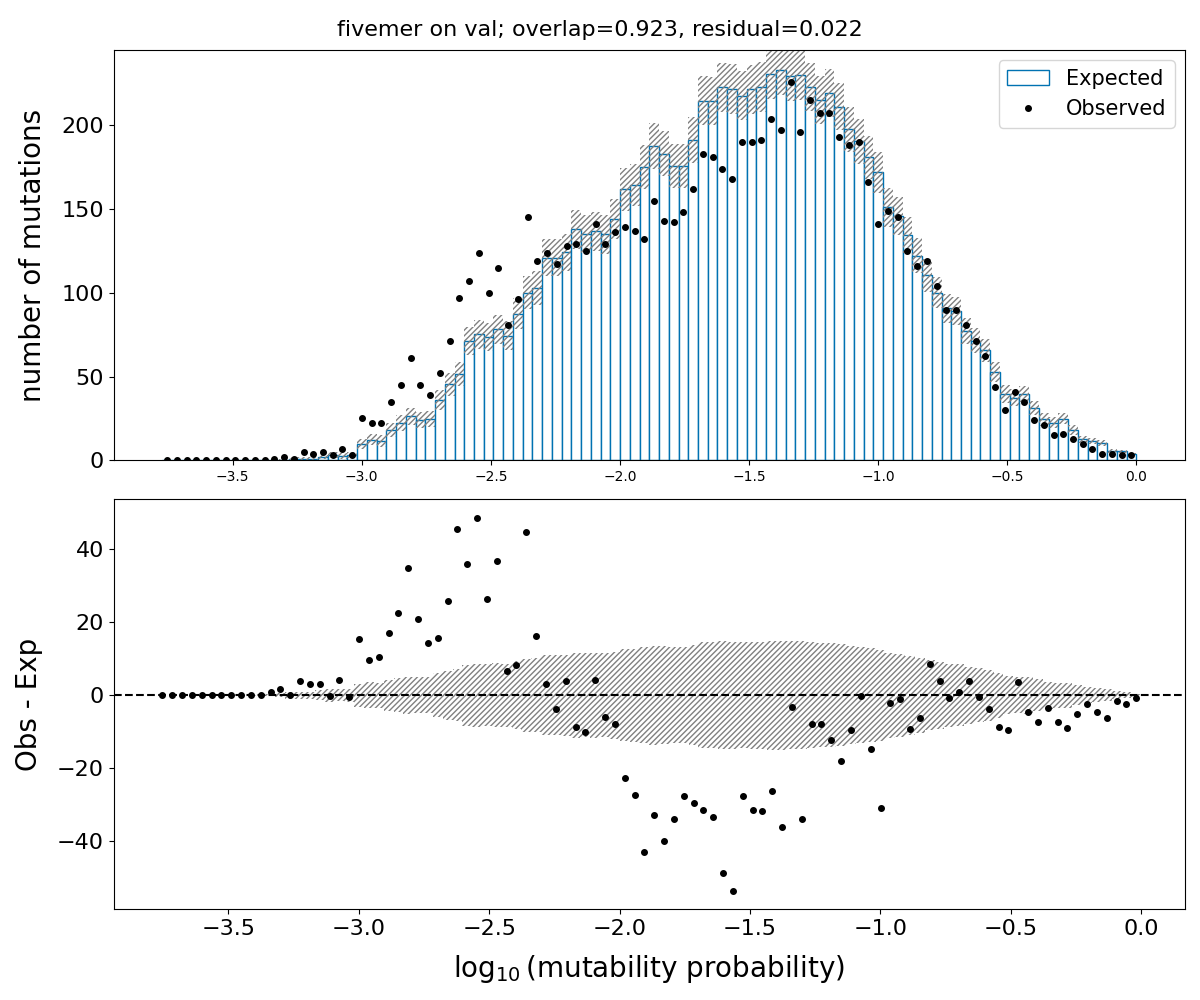

In [7]:
show_figure(oe_plot_of_crepe(fivemer_crepe, train_df, "fivemer on train")[0])
show_figure(oe_plot_of_crepe(fivemer_crepe, val_df, "fivemer on val")[0])

In [8]:
cnn_crepe = framework.load_crepe("trained_models/cnn_ind_lrg")

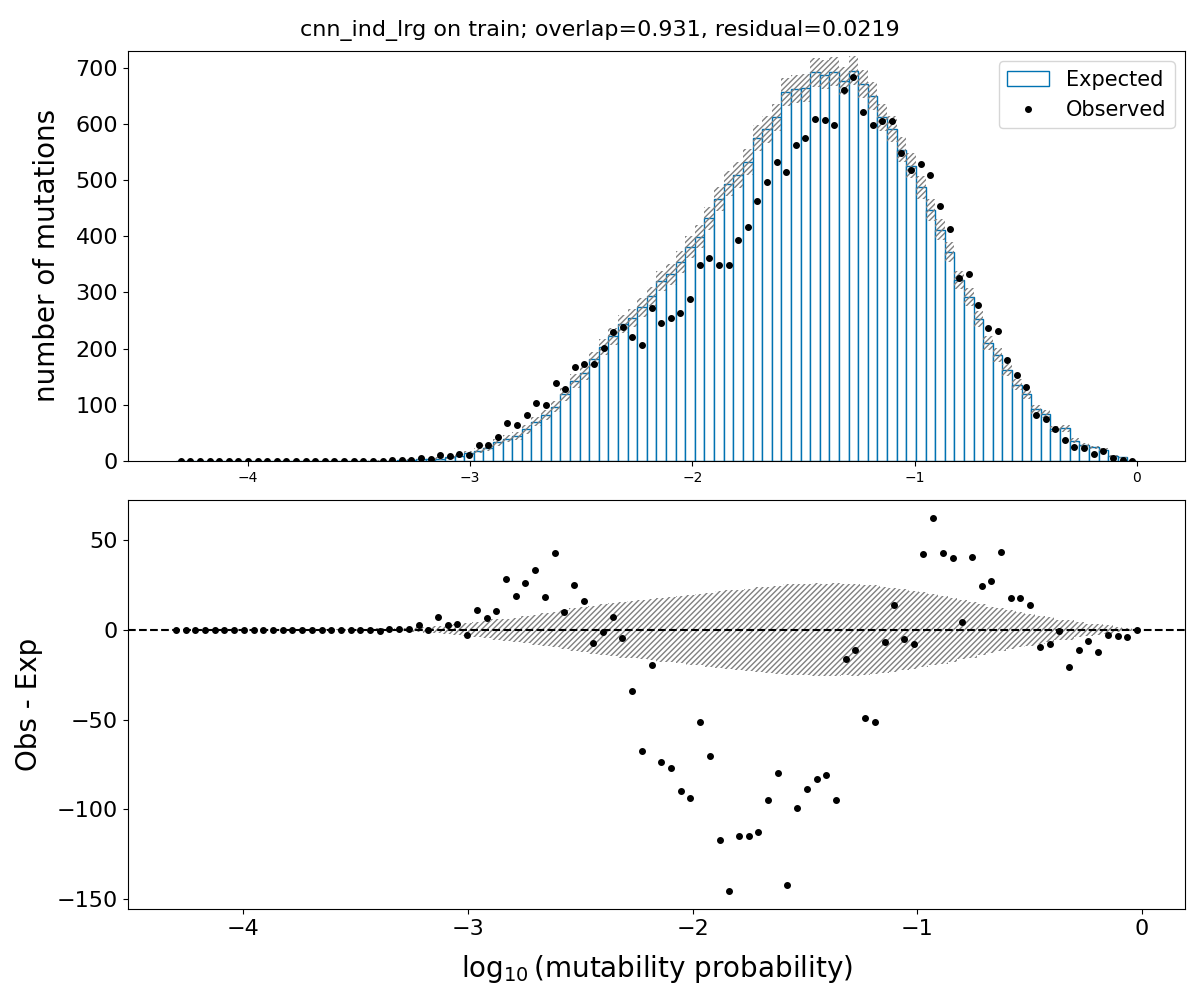

In [9]:
show_figure(oe_plot_of_crepe(cnn_crepe, subsampled_train_df, "cnn_ind_lrg on train")[0])

In [11]:
ermine_cnn_crepe = framework.load_crepe("../train/trained_models/cnn_ind_med-shmoof_small-fixed-0")

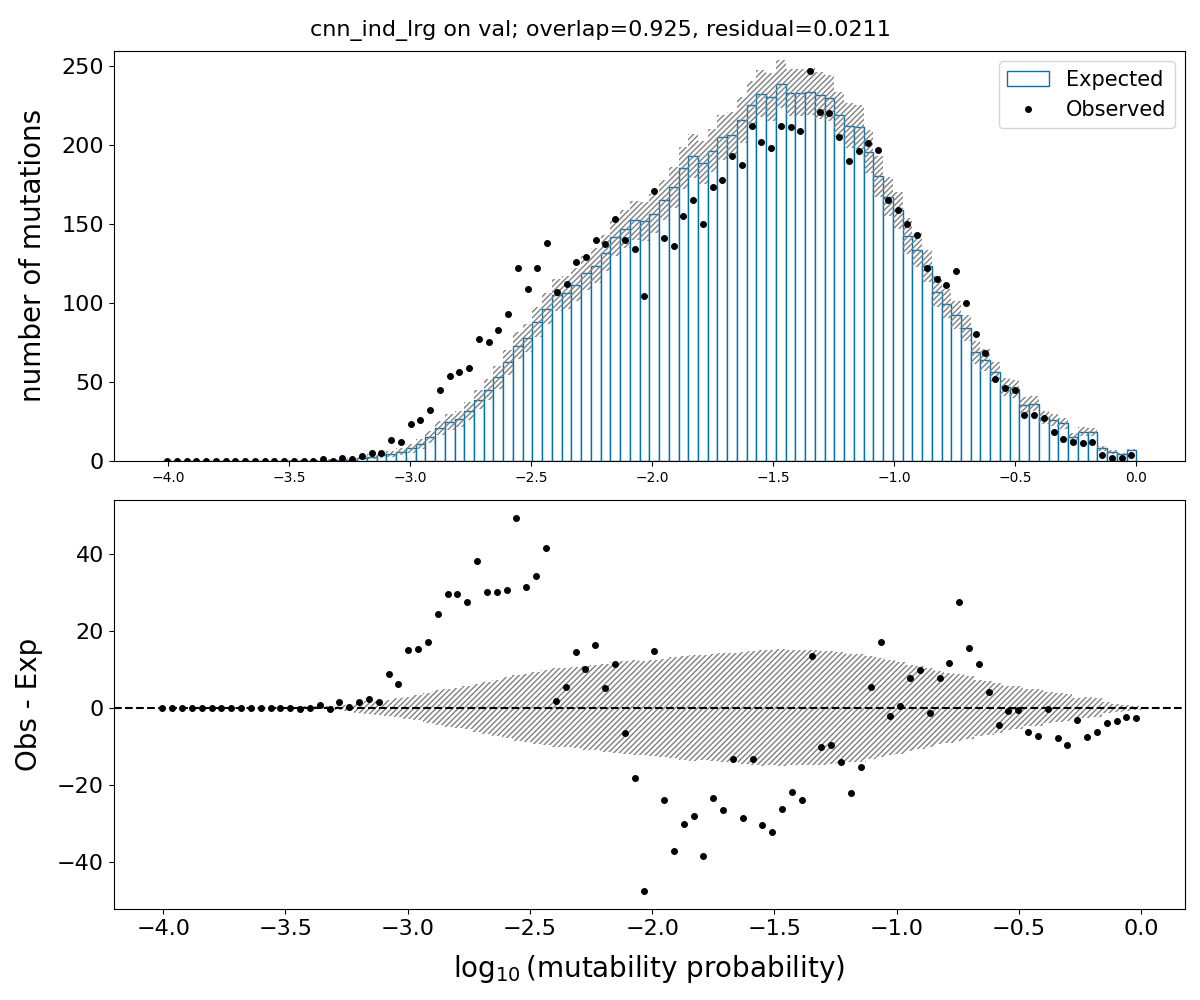

In [12]:
show_figure(oe_plot_of_crepe(ermine_cnn_crepe, val_df, "cnn_ind_lrg on val")[0])